In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import warnings
import kagglehub
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ReduceLROnPlateau, 
    ModelCheckpoint
)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [6]:
class MVTecDataLoader:
    """Data loader for MVTec Anomaly Detection Dataset"""
    
    def __init__(self, img_size=(224, 224), category='bottle'):
        # Download dataset from Kaggle and save to data/
        print("Downloading MVTec dataset from Kaggle...")
        downloaded_path = kagglehub.dataset_download("ipythonx/mvtec-ad")
        
        # Create data directory if it doesn't exist
        data_dir = Path("data")
        data_dir.mkdir(exist_ok=True)
        
        # Move the downloaded data to our data/ directory
        import shutil
        final_data_path = data_dir / "mvtec_anomaly_detection"
        
        # If the final path doesn't exist, copy from download location
        if not final_data_path.exists():
            print(f"Moving dataset from {downloaded_path} to {final_data_path}")
            shutil.copytree(downloaded_path, final_data_path)
        
        self.data_path = final_data_path
        self.img_size = img_size
        self.category = category
        print(f"Dataset ready at: {self.data_path}")
        
    def load_images(self, subset='train'):
        """Load images from specified subset (train/test)"""
        images = []
        labels = []
        
        subset_path = self.data_path / self.category / subset
        
        # Load normal images
        normal_path = subset_path / 'good'
        if normal_path.exists():
            for img_path in normal_path.glob('*.png'):
                img = self._preprocess_image(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(0)  # 0 for normal
        
        # Load anomalous images (only in test set)
        if subset == 'test':
            for anomaly_dir in subset_path.iterdir():
                if anomaly_dir.is_dir() and anomaly_dir.name != 'good':
                    for img_path in anomaly_dir.glob('*.png'):
                        img = self._preprocess_image(img_path)
                        if img is not None:
                            images.append(img)
                            labels.append(1)  # 1 for anomaly
        
        return np.array(images), np.array(labels)
    
    def _preprocess_image(self, img_path):
        """Preprocess individual image"""
        try:
            img = cv2.imread(str(img_path))
            if img is None:
                return None
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img.astype(np.float32) / 255.0
            return img
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            return None

# Initialize data loader
CATEGORY = 'bottle'  # Choose from available categories
IMG_SIZE = (224, 224)

loader = MVTecDataLoader(IMG_SIZE, CATEGORY)

# Load training data (only normal images)
train_images, train_labels = loader.load_images('train')
print(f"Training images shape: {train_images.shape}")
print(f"Training labels distribution: {np.bincount(train_labels)}")

# Load test data (normal + anomalous images)
test_images, test_labels = loader.load_images('test')
print(f"Test images shape: {test_images.shape}")
print(f"Test labels distribution: {np.bincount(test_labels)}")

Dataset ready at: data/mvtec_anomaly_detection
Training images shape: (209, 224, 224, 3)
Training labels distribution: [209]
Test images shape: (83, 224, 224, 3)
Test labels distribution: [20 63]


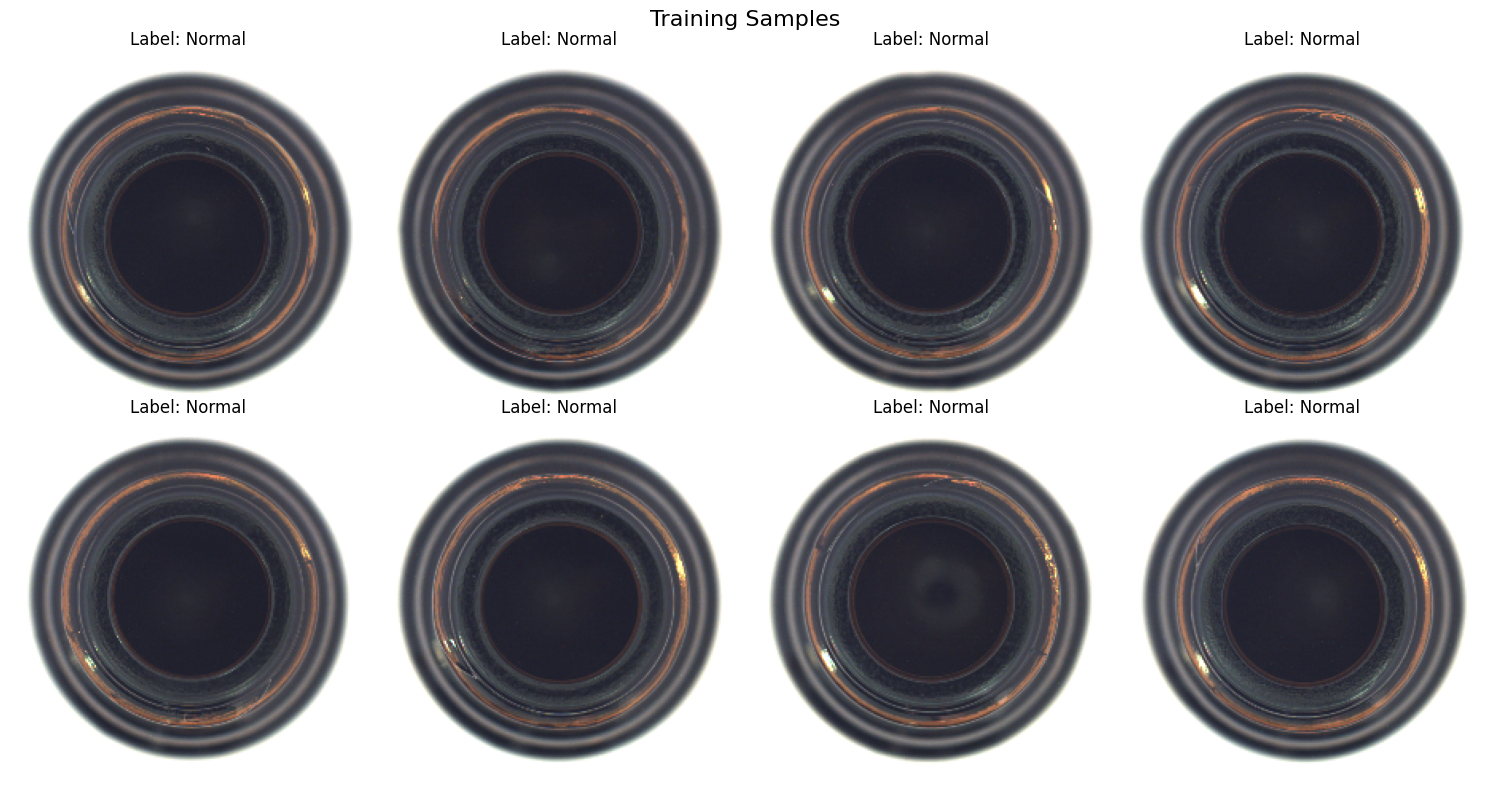

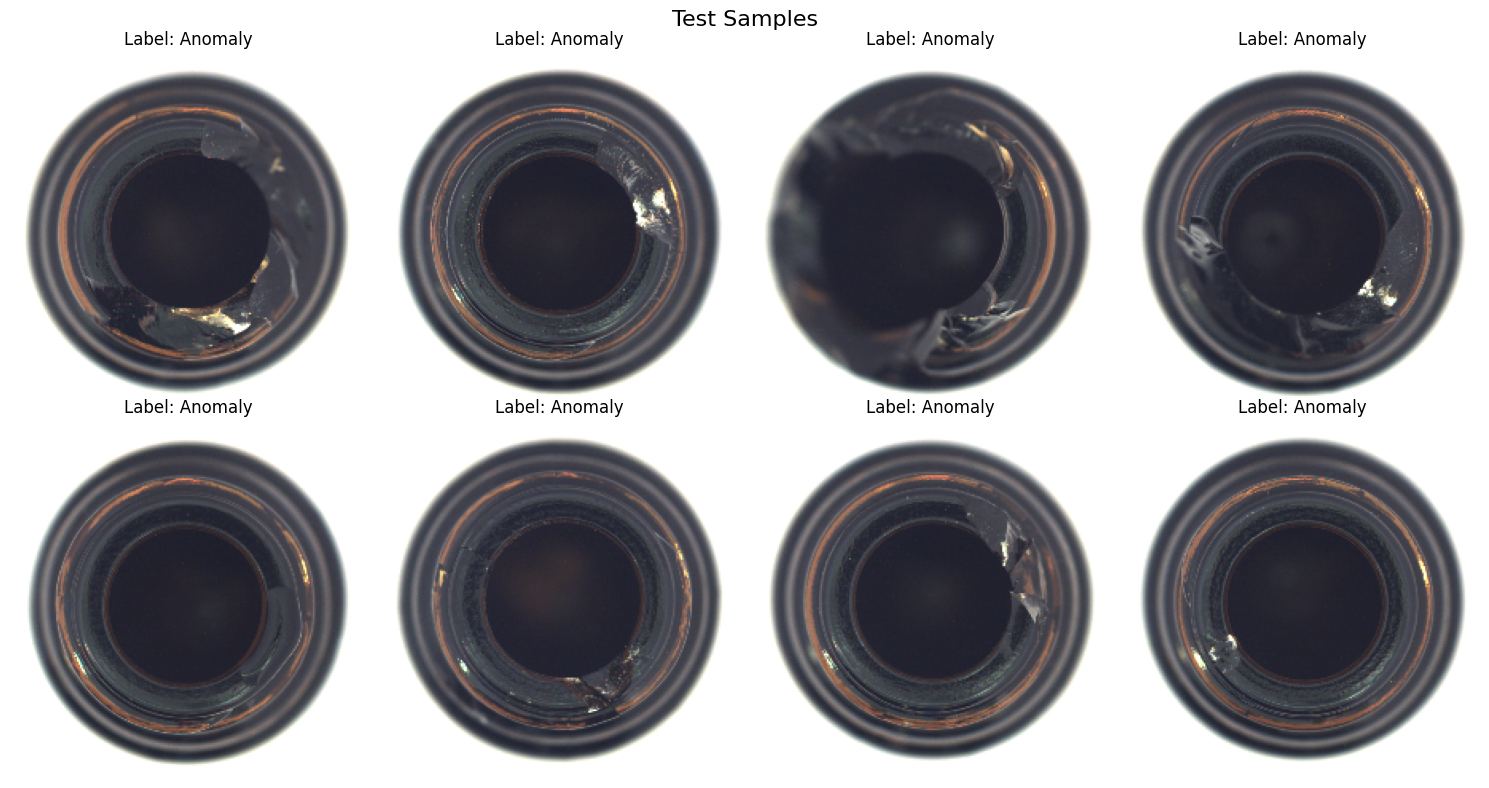

In [7]:
def visualize_samples(images, labels, num_samples=8, title="Samples"):
    """Visualize sample images"""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle(title, fontsize=16)
    
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        row, col = i // 4, i % 4
        axes[row, col].imshow(images[idx])
        axes[row, col].set_title(
            f"Label: {'Anomaly' if labels[idx] == 1 else 'Normal'}"
        )
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training samples
visualize_samples(train_images, train_labels, title="Training Samples")

# Visualize test samples
visualize_samples(test_images, test_labels, title="Test Samples")

In [8]:
class CNNAutoencoder:
    """CNN-based Autoencoder for anomaly detection"""
    
    def __init__(self, input_shape=(224, 224, 3)):
        self.input_shape = input_shape
        self.model = None
        
    def build_model(self):
        """Build the autoencoder model"""
        # Encoder
        encoder_input = layers.Input(shape=self.input_shape)
        
        # Encoder layers
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(
            encoder_input
        )
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
        
        # Decoder layers
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(
            encoded
        )
        x = layers.UpSampling2D((2, 2))(x)
        
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        
        # Output layer
        decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        
        # Create model
        self.model = Model(encoder_input, decoded)
        return self.model
    
    def compile_model(self, learning_rate=1e-3):
        """Compile the model"""
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mae']
        )
        
    def get_model_summary(self):
        """Get model summary"""
        return self.model.summary()

# Build and compile the model
autoencoder = CNNAutoencoder(input_shape=(*IMG_SIZE, 3))
model = autoencoder.build_model()
autoencoder.compile_model()

print("Model Architecture:")
autoencoder.get_model_summary()

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 28, 28, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 56, 56, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 224, 224, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,659 (5.21 MB)

 Trainable params: 1,366,659 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Split training data into train and validation
train_imgs, val_imgs = train_test_split(
    train_images, test_size=0.2, random_state=42
)

print(f"Training set size: {len(train_imgs)}")
print(f"Validation set size: {len(val_imgs)}")

# Create data generators
batch_size = 32

train_generator = train_datagen.flow(
    train_imgs, train_imgs,  # Input and target are the same for autoencoder
    batch_size=batch_size,
    shuffle=True
)

val_generator = ImageDataGenerator().flow(
    val_imgs, val_imgs,
    batch_size=batch_size,
    shuffle=False
)

Training set size: 167
Validation set size: 42


In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        f'models/best_autoencoder_{CATEGORY}.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Training parameters
EPOCHS = 100
STEPS_PER_EPOCH = len(train_imgs) // batch_size
VALIDATION_STEPS = len(val_imgs) // batch_size

In [11]:
# Train the model
print("Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Starting training...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1279 - mae: 0.3360
Epoch 1: val_loss improved from None to 0.11205, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.1253 - mae: 0.3335 - val_loss: 0.1120 - val_mae: 0.3200 - learning_rate: 0.0010
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.1141 - mae: 0.3222
Epoch 2: val_loss improved from 0.11205 to 0.10448, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.1141 - mae: 0.3222 - val_loss: 0.1045 - val_mae: 0.3121 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0978 - mae: 0.2980
Epoch 3: val_loss improved from 0.10448 to 0.07119, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0906 - mae: 0.2827 - val_loss: 0.0712 - val_mae: 0.2152 - learning_rate: 0.0010
Epoch 4/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0699 - mae: 0.2178
Epoch 4: val_loss did not improve from 0.07119
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0699 - mae: 0.2178 - val_loss: 0.0720 - val_mae: 0.2110 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0682 - mae: 0.2052
Epoch 5: val_loss improved from 0.07119 to 0.06009, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0673 - mae: 0.2010 - val_loss: 0.0601 - val_mae: 0.1770 - learning_rate: 0.0010
Epoch 6/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0594 - mae: 0.1795
Epoch 6: val_loss improved from 0.06009 to 0.05105, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0594 - mae: 0.1795 - val_loss: 0.0510 - val_mae: 0.1529 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0788 - mae: 0.1884
Epoch 7: val_loss did not improve from 0.05105
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0955 - mae: 0.2096 - val_loss: 0.0821 - val_mae: 0.2032 - learning_rate: 0.0010
Epoch 8/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0920 - mae: 0.2170
Epoch 8: val_loss improved from 0.05105 to 0.04818, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0920 - mae: 0.2170 - val_loss: 0.0482 - val_mae: 0.1488 - learning_rate: 0.0010
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - loss: 0.0553 - mae: 0.1654
Epoch 9: val_loss did not improve from 0.04818
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0594 - mae: 0.1736 - val_loss: 0.0536 - val_mae: 0.1628 - learning_rate: 0.0010
Epoch 10/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0551 - mae: 0.1686
Epoch 10: val_loss did not improve from 0.04818
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0551 - mae: 0.1686 - val_loss: 0.0528 - val_mae: 0.1597 - learning_rate: 0.0010
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - loss: 0.0512 - mae: 0.1572
Epoch 11: val_loss improved from 0.04818 to 0.04070, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0485 - mae: 0.1482 - val_loss: 0.0407 - val_mae: 0.1197 - learning_rate: 0.0010
Epoch 12/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0412 - mae: 0.1196
Epoch 12: val_loss improved from 0.04070 to 0.03537, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0412 - mae: 0.1196 - val_loss: 0.0354 - val_mae: 0.1109 - learning_rate: 0.0010
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - loss: 0.0354 - mae: 0.1119
Epoch 13: val_loss improved from 0.03537 to 0.02209, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0339 - mae: 0.1098 - val_loss: 0.0221 - val_mae: 0.0965 - learning_rate: 0.0010
Epoch 14/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0283 - mae: 0.1079
Epoch 14: val_loss improved from 0.02209 to 0.02126, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0283 - mae: 0.1079 - val_loss: 0.0213 - val_mae: 0.0974 - learning_rate: 0.0010
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - loss: 0.0282 - mae: 0.1099
Epoch 15: val_loss did not improve from 0.02126
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0280 - mae: 0.1096 - val_loss: 0.0224 - val_mae: 0.0995 - learning_rate: 0.0010
Epoch 16/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0262 - mae: 0.1026
Epoch 16: val_loss improved from 0.02126 to 0.01918, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0262 - mae: 0.1026 - val_loss: 0.0192 - val_mae: 0.0898 - learning_rate: 0.0010
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - loss: 0.0246 - mae: 0.0982
Epoch 17: val_loss did not improve from 0.01918
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0244 - mae: 0.0978 - val_loss: 0.0227 - val_mae: 0.0910 - learning_rate: 0.0010
Epoch 18/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0237 - mae: 0.0922
Epoch 18: val_loss did not improve from 0.01918
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0237 - mae: 0.0922 - val_loss: 0.0195 - val_mae: 0.0842 - learning_rate: 0.0010
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - loss: 0.0223 - mae: 0.0893
Epoch 19: val_loss did not improve from 0.01918
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0223 - mae: 0.0884 - val_loss: 0.0244 - val_mae: 0.0904 - learning_rate: 0.0010
Epoch 20/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0235 - mae: 0.0899
Epoch 20: val_loss improved fr

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0235 - mae: 0.0899 - val_loss: 0.0182 - val_mae: 0.0853 - learning_rate: 0.0010
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - loss: 0.0212 - mae: 0.0900
Epoch 21: val_loss improved from 0.01816 to 0.01707, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0207 - mae: 0.0865 - val_loss: 0.0171 - val_mae: 0.0765 - learning_rate: 0.0010
Epoch 22/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0186 - mae: 0.0787
Epoch 22: val_loss improved from 0.01707 to 0.01462, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0186 - mae: 0.0787 - val_loss: 0.0146 - val_mae: 0.0738 - learning_rate: 0.0010
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - loss: 0.0225 - mae: 0.0875
Epoch 23: val_loss did not improve from 0.01462
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0235 - mae: 0.0902 - val_loss: 0.0296 - val_mae: 0.0987 - learning_rate: 0.0010
Epoch 24/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0250 - mae: 0.0899
Epoch 24: val_loss did not improve from 0.01462
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0250 - mae: 0.0899 - val_loss: 0.0220 - val_mae: 0.0855 - learning_rate: 0.0010
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - loss: 0.0219 - mae: 0.0862
Epoch 25: val_loss did not improve from 0.01462
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0217 - mae: 0.0859 - val_loss: 0.0199 - val_mae: 0.0816 - learning_rate: 0.0010
Epoch 26/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0202 - mae: 0.0822
Epoch 26: val_loss did not imp

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0172 - mae: 0.0778 - val_loss: 0.0140 - val_mae: 0.0715 - learning_rate: 5.0000e-04
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - loss: 0.0177 - mae: 0.0786
Epoch 31: val_loss did not improve from 0.01396
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 968ms/step - loss: 0.0178 - mae: 0.0781 - val_loss: 0.0166 - val_mae: 0.0740 - learning_rate: 5.0000e-04
Epoch 32/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0175 - mae: 0.0760
Epoch 32: val_loss improved from 0.01396 to 0.01374, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0175 - mae: 0.0760 - val_loss: 0.0137 - val_mae: 0.0690 - learning_rate: 5.0000e-04
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0170 - mae: 0.0758
Epoch 33: val_loss did not improve from 0.01374
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0170 - mae: 0.0753 - val_loss: 0.0150 - val_mae: 0.0700 - learning_rate: 5.0000e-04
Epoch 34/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0163 - mae: 0.0736
Epoch 34: val_loss improved from 0.01374 to 0.01163, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0163 - mae: 0.0736 - val_loss: 0.0116 - val_mae: 0.0641 - learning_rate: 5.0000e-04
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - loss: 0.0163 - mae: 0.0725
Epoch 35: val_loss improved from 0.01163 to 0.01140, saving model to best_autoencoder_bottle.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 963ms/step - loss: 0.0159 - mae: 0.0713 - val_loss: 0.0114 - val_mae: 0.0629 - learning_rate: 5.0000e-04
Epoch 36/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0155 - mae: 0.0710
Epoch 36: val_loss did not improve from 0.01140
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0155 - mae: 0.0710 - val_loss: 0.0120 - val_mae: 0.0641 - learning_rate: 5.0000e-04
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - loss: 0.0159 - mae: 0.0720
Epoch 37: val_loss did not improve from 0.01140
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 963ms/step - loss: 0.0158 - mae: 0.0718 - val_loss: 0.0151 - val_mae: 0.0683 - learning_rate: 5.0000e-04
Epoch 38/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0149 - mae: 0.0691
Epoch 38: val_loss did not improve from 0.01140
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0149 - mae: 0.0691 - val_loss: 0.0148 - val_mae: 0.0673 - learning_rate: 5.0000e-04
Epoch 39/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - loss: 0.0155 - mae: 0.0695
Epoch 39

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 968ms/step - loss: 0.0155 - mae: 0.0694 - val_loss: 0.0109 - val_mae: 0.0612 - learning_rate: 5.0000e-04
Epoch 40/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0142 - mae: 0.0678
Epoch 40: val_loss did not improve from 0.01092
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0142 - mae: 0.0678 - val_loss: 0.0110 - val_mae: 0.0608 - learning_rate: 5.0000e-04
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - loss: 0.0159 - mae: 0.0699
Epoch 41: val_loss did not improve from 0.01092
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 967ms/step - loss: 0.0156 - mae: 0.0693 - val_loss: 0.0128 - val_mae: 0.0636 - learning_rate: 5.0000e-04
Epoch 42/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0150 - mae: 0.0689
Epoch 42: val_loss did not improve from 0.01092
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0150 - mae: 0.0689 - val_loss: 0.0135 - val_mae: 0.0649 - learning_rate: 5.0000e-04
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - loss: 0.0140 - mae: 0.0674
Epoch 43

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0139 - mae: 0.0656 - val_loss: 0.0087 - val_mae: 0.0560 - learning_rate: 5.0000e-04
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - loss: 0.0152 - mae: 0.0685
Epoch 45: val_loss did not improve from 0.00875
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 961ms/step - loss: 0.0151 - mae: 0.0689 - val_loss: 0.0100 - val_mae: 0.0591 - learning_rate: 5.0000e-04
Epoch 46/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0139 - mae: 0.0670
Epoch 46: val_loss did not improve from 0.00875
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0139 - mae: 0.0670 - val_loss: 0.0138 - val_mae: 0.0641 - learning_rate: 5.0000e-04
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - loss: 0.0146 - mae: 0.0664
Epoch 47: val_loss did not improve from 0.00875
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 965ms/step - loss: 0.0146 - mae: 0.0663 - val_loss: 0.0134 - val_mae: 0.0633 - learning_rate: 5.0000e-04
Epoch 48/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0144 - mae: 0.0663
Epoch 48

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 968ms/step - loss: 0.0143 - mae: 0.0671 - val_loss: 0.0087 - val_mae: 0.0552 - learning_rate: 5.0000e-04
Epoch 50/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0145 - mae: 0.0665
Epoch 50: val_loss did not improve from 0.00873
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0145 - mae: 0.0665 - val_loss: 0.0092 - val_mae: 0.0556 - learning_rate: 2.5000e-04
Epoch 51/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - loss: 0.0142 - mae: 0.0656
Epoch 51: val_loss did not improve from 0.00873
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 976ms/step - loss: 0.0142 - mae: 0.0656 - val_loss: 0.0101 - val_mae: 0.0581 - learning_rate: 2.5000e-04
Epoch 52/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0131 - mae: 0.0646
Epoch 52: val_loss did not improve from 0.00873
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0131 - mae: 0.0646 - val_loss: 0.0097 - val_mae: 0.0577 - learning_rate: 2.5000e-04
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - loss: 0.0139 - mae: 0.0661
Epoch 53

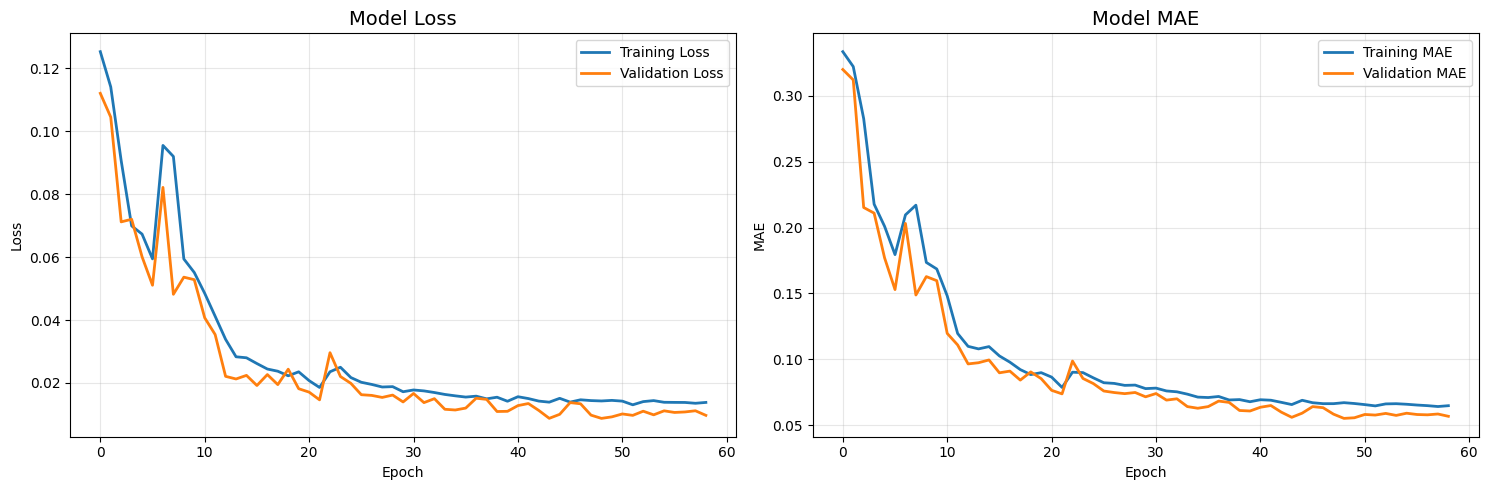

In [12]:
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot MAE
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    ax2.set_title('Model MAE', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [13]:
def calculate_reconstruction_error(model, images):
    """Calculate reconstruction error for images"""
    reconstructed = model.predict(images, verbose=0)
    errors = np.mean(np.square(images - reconstructed), axis=(1, 2, 3))
    return errors

def evaluate_anomaly_detection(model, test_images, test_labels):
    """Evaluate anomaly detection performance"""
    # Calculate reconstruction errors
    reconstruction_errors = calculate_reconstruction_error(model, test_images)
    
    # Calculate AUC score
    auc_score = roc_auc_score(test_labels, reconstruction_errors)
    
    # Find optimal threshold using validation data
    normal_errors = reconstruction_errors[test_labels == 0]
    anomaly_errors = reconstruction_errors[test_labels == 1]
    
    threshold = np.percentile(normal_errors, 95)  # 95th percentile of normal errors
    
    # Make predictions
    predictions = (reconstruction_errors > threshold).astype(int)
    
    return {
        'auc_score': auc_score,
        'threshold': threshold,
        'reconstruction_errors': reconstruction_errors,
        'predictions': predictions,
        'normal_errors': normal_errors,
        'anomaly_errors': anomaly_errors
    }

# Evaluate the model
results = evaluate_anomaly_detection(model, test_images, test_labels)

print(f"AUC Score: {results['auc_score']:.4f}")
print(f"Optimal Threshold: {results['threshold']:.6f}")
print("\nClassification Report:")
print(classification_report(test_labels, results['predictions']))

AUC Score: 0.5802
Optimal Threshold: 0.010703

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.95      0.43        20
           1       0.93      0.21      0.34        63

    accuracy                           0.39        83
   macro avg       0.60      0.58      0.38        83
weighted avg       0.77      0.39      0.36        83



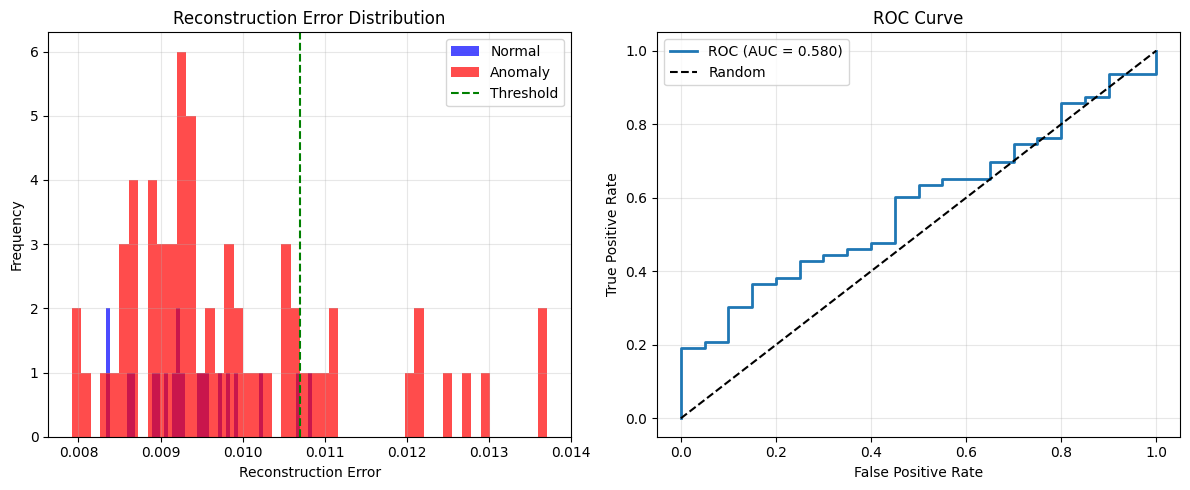

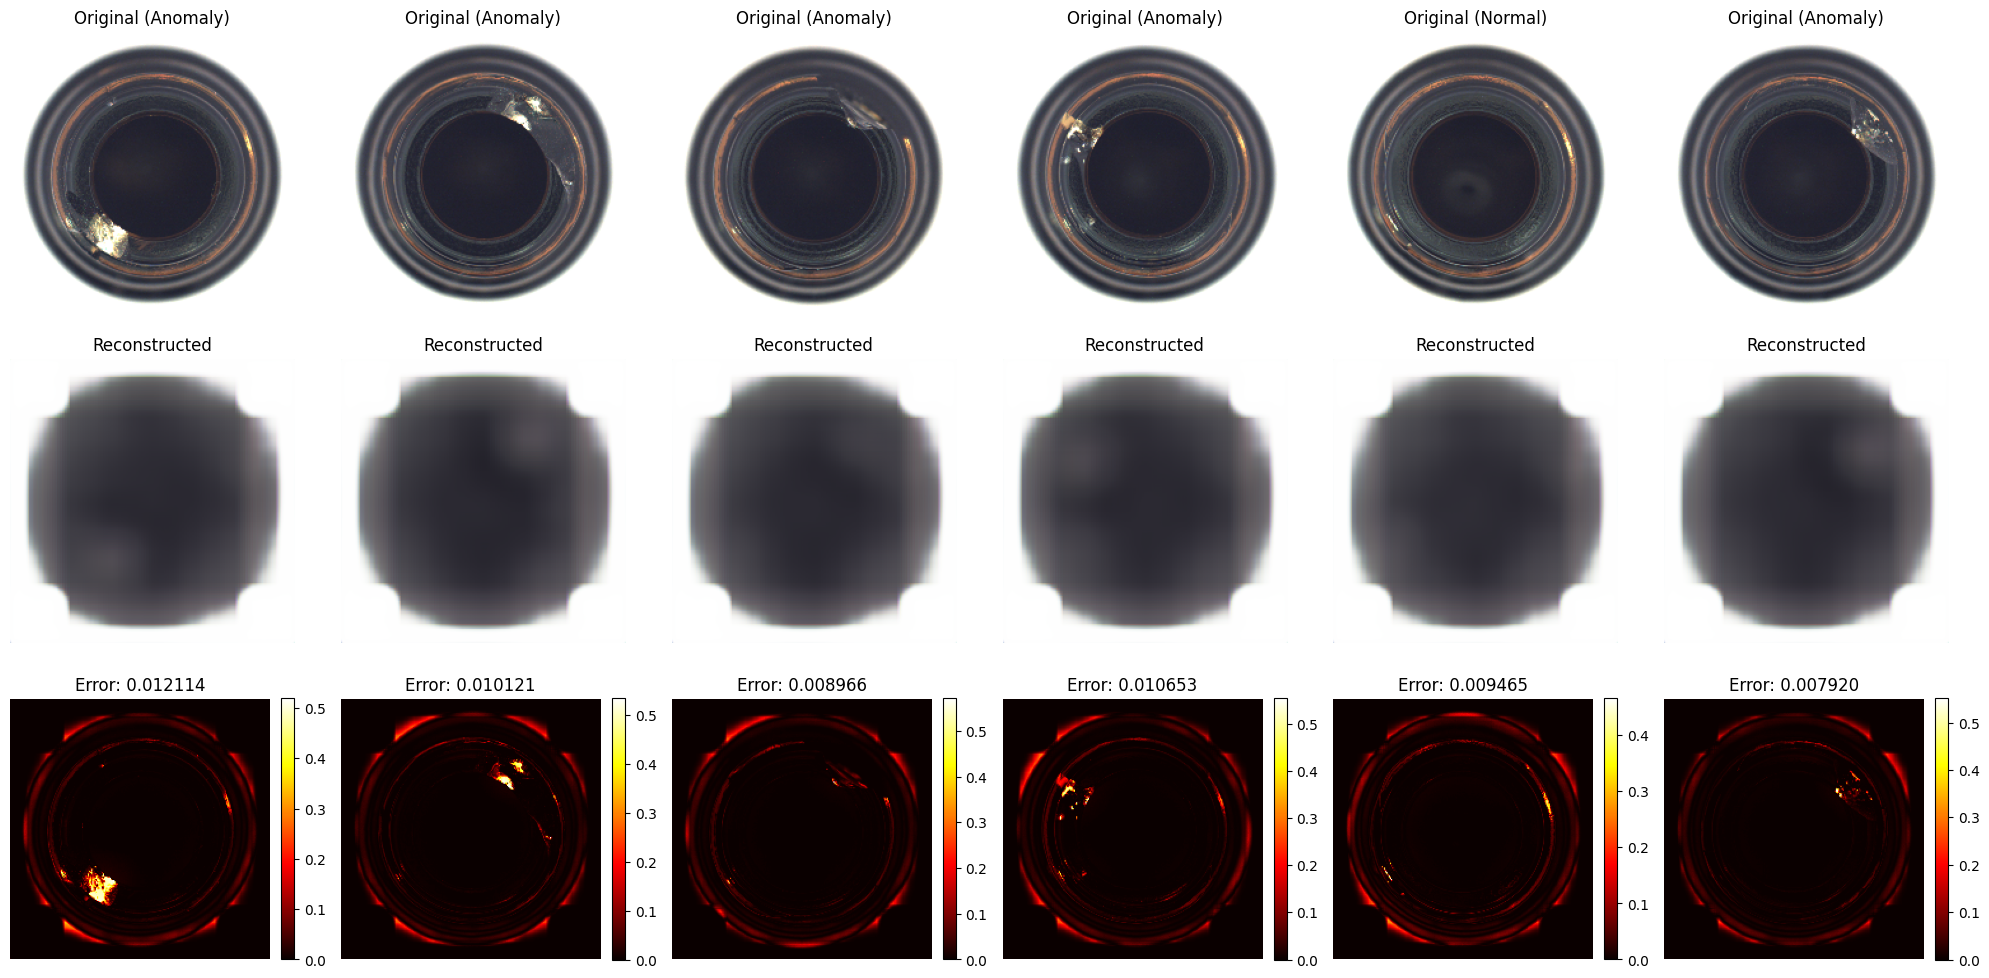

In [14]:
def plot_reconstruction_errors(results):
    """Plot reconstruction error distributions"""
    plt.figure(figsize=(12, 5))
    
    # Plot error distributions
    plt.subplot(1, 2, 1)
    plt.hist(results['normal_errors'], bins=50, alpha=0.7, label='Normal', color='blue')
    plt.hist(results['anomaly_errors'], bins=50, alpha=0.7, label='Anomaly', color='red')
    plt.axvline(results['threshold'], color='green', linestyle='--', label='Threshold')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Reconstruction Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # ROC curve visualization
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(test_labels, results['reconstruction_errors'])
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {results["auc_score"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_reconstructions(model, images, labels, num_samples=6):
    """Visualize original vs reconstructed images"""
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 10))
    
    reconstructed = model.predict(images[indices], verbose=0)
    errors = calculate_reconstruction_error(model, images[indices])
    
    for i in range(num_samples):
        # Original image
        axes[0, i].imshow(images[indices[i]])
        axes[0, i].set_title(f"Original ({'Anomaly' if labels[indices[i]] == 1 else 'Normal'})")
        axes[0, i].axis('off')
        
        # Reconstructed image
        axes[1, i].imshow(reconstructed[i])
        axes[1, i].set_title(f"Reconstructed")
        axes[1, i].axis('off')
        
        # Error map
        error_map = np.mean(np.square(images[indices[i]] - reconstructed[i]), axis=2)
        im = axes[2, i].imshow(error_map, cmap='hot')
        axes[2, i].set_title(f"Error: {errors[i]:.6f}")
        axes[2, i].axis('off')
        plt.colorbar(im, ax=axes[2, i], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Visualize results
plot_reconstruction_errors(results)
visualize_reconstructions(model, test_images, test_labels)

In [ ]:
# Save the final model
from datetime import datetime

model_name = f'mvtec_autoencoder_{CATEGORY}_final_{datetime.now().strftime("%Y%m%d_%H%M%S")}.h5'
model.save(f'models/{model_name}')
print(f"Model saved as 'models/{model_name}'")

# Print final summary
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Dataset Category: {CATEGORY}")
print(f"Image Size: {IMG_SIZE}")
print(f"Training Samples: {len(train_images)}")
print(f"Test Samples: {len(test_images)}")
print(f"AUC Score: {results['auc_score']:.4f}")
print(f"Threshold: {results['threshold']:.6f}")
print("="*50)

Model saved as 'mvtec_autoencoder_bottle_final.h5'

FINAL RESULTS SUMMARY
Dataset Category: bottle
Image Size: (224, 224)
Training Samples: 209
Test Samples: 83
AUC Score: 0.5802
Threshold: 0.010703
